In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)

import pickle
from pathlib import Path

from yadlt.model import PDFmodel
from yadlt.distribution import Distribution

In [2]:
# Extension for the weights file
WEIGHTS_TOKEN = 'weights.h5'
def select_weight(epoch: int):
  return f"epoch_{int(epoch)}.{WEIGHTS_TOKEN}"

In [3]:
# Path to the fit folder
FIT_FOLDER = Path('../Results/fits/250604-ac-03-L2')

# Folder for the serialization
SERIALIZATION_FOLDER = FIT_FOLDER / 'serialization'
SERIALIZATION_FOLDER.mkdir(parents=True, exist_ok=True)

# Path to plot folder
PLOT_FOLDER = FIT_FOLDER / 'plots'
PLOT_FOLDER.mkdir(parents=True, exist_ok=True)

SAVE_PLOT = True
SAVE_NB = False

# Plot error bars instead of lines
PLOT_ERROR_BARS = True

# Force serialization
FORCE_SERIALIZATION = True

In [4]:
# Get learning rate from config file
import yaml
try:
  with open(FIT_FOLDER / 'metadata.yaml', 'r') as f:
    metadata = yaml.safe_load(f)
    learning_rate = metadata['arguments']['learning_rate']

except FileNotFoundError:
  print("Metadata file not found. Using default learning rate.")
  learning_rate = 1.e-5

In [5]:
# Extract replicas from the fit folder
replicas_folders = [f for f in FIT_FOLDER.iterdir() if f.is_dir() and 'replica' in str(f)]
replicas_folders.sort()
replicas = len(replicas_folders)

# For each replicas, load the epochs and data
replica_epochs_dict = {}
for replica_folder in replicas_folders:
  epochs = [f for f in replica_folder.iterdir() if f.is_file() and WEIGHTS_TOKEN in str(f)]
  epochs.sort()
  replica_epochs_dict[replica_folder.name] = epochs

In [6]:
# Find common epochs
# Different replicas may have different epochs, so we need to find the common ones
common_epochs = set()
for replica, epochs in replica_epochs_dict.items():
  aux = set()
  for epoch in epochs:
    epoch_num = int(epoch.name.split('.')[0].split('_')[1])
    aux.add(epoch_num)
  
  if len(common_epochs) == 0:
    common_epochs = aux
  else:
    common_epochs.intersection_update(aux)

common_epochs = sorted(list(common_epochs))
print(f"Common epochs: {common_epochs}")

Common epochs: [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000]


In [7]:
from yadlt import data
from pathlib import Path
import importlib.resources as pkg_resources

# Load Tommaso's file
data_path = Path(pkg_resources.files(data) / "BCDMS_data")
fk_grid = np.load(data_path / 'fk_grid.npy')
FK = np.load(data_path / 'FK.npy')
f_bcdms = np.load(data_path / 'f_bcdms.npy')
Cy = np.load(data_path / 'Cy.npy')
Cinv = np.linalg.inv(Cy)

# Compute M
M = FK.T @ Cinv @ FK

In [8]:
# Extract the last common epoch from the ensemble of replicas
xT3_training = Distribution('xT3_training')
print(f'Loading {len(replicas_folders)} replicas...', end='\t')
for replica_path in replicas_folders:
    replica = replica_path.name
    last_epoch = replica_epochs_dict[replica][-1]

    model = PDFmodel.load_model(replica_path / 'config.json', last_epoch)
    xT3_training.add(model.predict().numpy().reshape(-1))
print('Done!')

# Compute T3 from xT3
T3_training = xT3_training.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at the end of the training')

Loading 100 replicas...	Done!


In [9]:
# Load the data used to fit the replicas
data_by_replica_original = Distribution("Original replicas of the data")

for rep in range(replicas):
  data = np.load(FIT_FOLDER / f'replica_{rep+1}' / 'data.npy')
  data_by_replica_original.add(data)

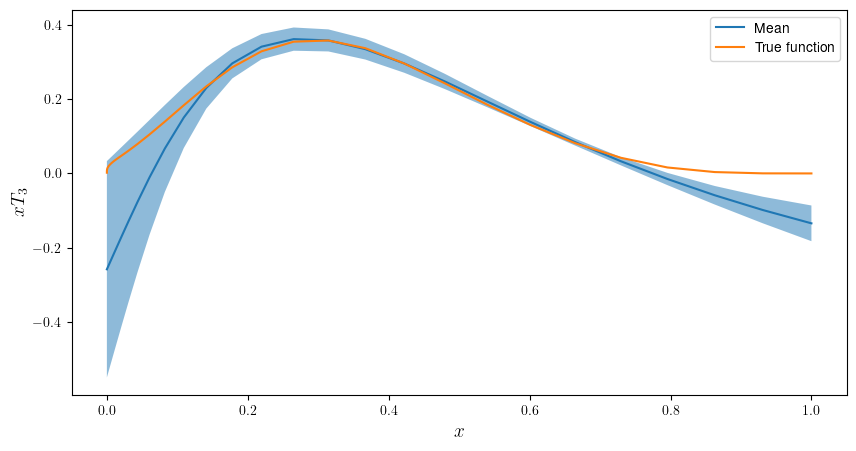

In [10]:
# Plot the ensemble of xT3 at the end of the training
plt.figure(figsize=(10, 5))
plt.plot(fk_grid, xT3_training.get_mean(), label='Mean')
plt.fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
plt.plot(fk_grid, f_bcdms, label='True function')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$xT_3$', fontsize=14)
plt.legend()
plt.show()
if SAVE_PLOT:
  plt.savefig(PLOT_FOLDER / 'pdf_mean_std.png', dpi=300)
plt.close()

In [11]:
import tensorflow as tf
@tf.function(reduce_retracing=True)
def compute_ntk_static(inputs, model, outputs):
    """
    Optimized Neural Tangent Kernel computation.
    This function computes the NTK in a more efficient way by
    leveraging static shapes and avoiding unnecessary operations.

    This function avoids reretracing by using `tf.function` with `reduce_retracing=True`.

    Albeit a similar function exists in the model class, this one is optimized and
    avoid retracing by using static shapes and a single operation to compute the NTK.

    TODO: The two functions should be merged, but this requires some refactoring
    """
    with tf.GradientTape(persistent=False) as tape:
        predictions = model(inputs)
        jacobian = tape.jacobian(predictions, model.trainable_variables)

    input_size = inputs.shape[0]

    if outputs == 1:
        # Concatenate jacobians along the parameter dimension
        jac_list = []
        for jac in jacobian:
            # Flatten dimension
            jac_flat = tf.reshape(jac, (input_size, -1))
            jac_list.append(jac_flat)
        
        # Concatenate all parameter jacobians
        full_jacobian = tf.concat(jac_list, axis=1)  # Shape: [input_size, total_params]

          # Compute NTK in one operation
        ntk = tf.matmul(full_jacobian, full_jacobian, transpose_b=True)
        
    else:
        # Multiple outputs case
        raise NotImplementedError(
            "Multiple outputs optimization not implemented. Use original method."
        )

    return ntk

In [12]:
# Get one model structure to use for NTK computation
dummy_model = PDFmodel.load_model(replicas_folders[0] / 'config.json', replicas_folders[0] / select_weight(0)).model

# Calling the model with a dummy input makes sure the model is built
# Not sure this is strictly necessary, but it is a good practice
_ = dummy_model(tf.convert_to_tensor(fk_grid.reshape(-1, 1)))

def process_replica_by_epoch(replica_path: Path, epoch: int, tol=1e-7):
    """
    Process a single replica for a given epoch,
    """
    # Compute the NTK for the current replica and epoch
    dummy_model.load_weights(replica_path / select_weight(epoch))
    NTK = compute_ntk_static(tf.convert_to_tensor(fk_grid.reshape(-1, 1)), dummy_model, outputs=1)

    size = NTK.shape[0]

    # Compute eigenvalues and eigenvectors of the NTK
    Z, eigenvalues, ZrT = np.linalg.svd(NTK, hermitian=True)

    # Compute frobenius norm
    frob_norm = np.sqrt(np.sum([s**2 for s in eigenvalues]))

    # Split the NTK space
    # rtol = tol * eigenvalues.max()
    # perp_mask = eigenvalues > rtol
    # parallel_mask = ~perp_mask

    for idx in range(len(eigenvalues)):
      if not np.allclose(Z[:,idx], ZrT.T[:,idx]):
        cut = idx
        break
    
    for i in range(cut, 0, -1):
        if eigenvalues[i] / eigenvalues[0] > 1.e-7:
            cut = np.int64(i + 1)
            break
               

    perp_mask = [True] * cut + [False] * (size - cut)
    parallel_mask = ~np.array(perp_mask)

    Lambda_perp  = eigenvalues[perp_mask]
    Z_perp = Z[:, perp_mask]
    Z_parallel = Z[:, parallel_mask]

    # Parallel projector
    P_parallel = np.empty((size, size))
    P_perp = np.empty((size, size))
    P_parallel = np.dot(Z_parallel, Z_parallel.T)
    P_perp = np.dot(Z_perp, Z_perp.T)

    # Compute similarity transformation
    Lambda_perp_sqrt = np.sqrt(Lambda_perp)
    Lambda_perp_sqrt_inv = 1.0 / Lambda_perp_sqrt
    P = np.diag(Lambda_perp_sqrt_inv) @ Z_perp.T
    P_inv = Z_perp @ np.diag(Lambda_perp_sqrt)

    # Symmetric operator
    H_perp = np.diag(Lambda_perp_sqrt) @ Z_perp.T @ M @ Z_perp @ np.diag(Lambda_perp_sqrt)

    # Eigendecomposition of H_perp
    h, W = np.linalg.eigh(H_perp)
    hinv = 1 / h

    # Compute Q and its inverse
    Q = P_inv @ W
    Qinv = W.T @ P

    # Pad quantities to ensure they are square matrices
    Q = np.pad(Q, ((0, 0), (0, Q.shape[0] - Q.shape[1])), mode='constant', constant_values=0)
    Qinv = np.pad(Qinv, ((0, Qinv.shape[1] - Qinv.shape[0]), (0, 0)), mode='constant', constant_values=0)
    hinv = np.pad(hinv, (0, Q.shape[0] - hinv.shape[0]), mode='constant', constant_values=0)
    h = np.pad(h, (0, Q.shape[0] - h.shape[0]), mode='constant', constant_values=0)

    return {
        'NTK': NTK,
        'Z': Z,
        'frob_norm': frob_norm,
        'eigenvalues': eigenvalues,
        'P_parallel': P_parallel,
        'P_perp': P_perp,
        'Q': Q,
        'Qinv': Qinv,
        'h': h,
        'hinv': hinv,
        'cut': cut
    }

In [13]:
# Collect NTK data and other quantities over time
#TODO Maybe I serialize too many quantities, I should only keep the ones I need
#TODO This is too much of a boilerplate, I should refactor this code to avoid repetition
#TODO This process can be parallelized

# Tolerance for NTK splitting
#tol = 0.001 # Tolerance for zero eigenvalues

if not any(SERIALIZATION_FOLDER.iterdir()) or FORCE_SERIALIZATION:
  print('Data have not been serialized. Serializing now...')
  NTK_time = [Distribution(name=f'NTK at epoch {epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size,)) for epoch in common_epochs]
  frob_norm_time = [Distribution(name=f'Frobenius norm at epoch {epoch}', size=replicas, shape=()) for epoch in common_epochs]
  eigvals_time = [Distribution(name=f'Eigenvalues of the NTK at epoch {epoch}', size=replicas, shape=(fk_grid.size,)) for epoch in common_epochs]
  eigvecs_time = [Distribution(name=f'Eigenvectors of the NTK at epoch {epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size)) for epoch in common_epochs]

  P_parallel_by_epoch = [Distribution(name=f'P at parallel epoch {epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size,)) for epoch in common_epochs]
  P_perp_by_epoch = [Distribution(name=f'P at perpendicular epoch {epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size,)) for epoch in common_epochs]

  Q_by_epoch = [Distribution(name=f'Q at epoch {epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size,)) for epoch in common_epochs]
  Qinv_by_epoch = [Distribution(name=f'Q inv. at epoch {epoch}', size=replicas, shape=(fk_grid.size, fk_grid.size,)) for epoch in common_epochs]
  h_by_epoch = [Distribution(name=f'h at epoch {epoch}', size=replicas, shape=(fk_grid.size,)) for epoch in common_epochs]
  hinv_by_epoch = [Distribution(name=f'h at epoch {epoch}', size=replicas, shape=(fk_grid.size,)) for epoch in common_epochs]
  cut_by_epoch = [Distribution(name=f'cut at epoch {epoch}', size=replicas, shape=()) for epoch in common_epochs]

  for epoch in common_epochs:
    print(f"Epoch {epoch} / {common_epochs[-1]}")

    # Loop over each replica
    for replica_path in replicas_folders:
      
      result = process_replica_by_epoch(replica_path, epoch)

      NTK_time[common_epochs.index(epoch)].add(result['NTK'])
      frob_norm_time[common_epochs.index(epoch)].add(result['frob_norm'])
      eigvals_time[common_epochs.index(epoch)].add(result['eigenvalues'])
      eigvecs_time[common_epochs.index(epoch)].add(result['Z'])

      P_parallel_by_epoch[common_epochs.index(epoch)].add(result['P_parallel'])
      P_perp_by_epoch[common_epochs.index(epoch)].add(result['P_perp'])

      h_by_epoch[common_epochs.index(epoch)].add(result['h'])
      hinv_by_epoch[common_epochs.index(epoch)].add(result['hinv'])
      Q_by_epoch[common_epochs.index(epoch)].add(result['Q'])
      Qinv_by_epoch[common_epochs.index(epoch)].add(result['Qinv'])
      cut_by_epoch[common_epochs.index(epoch)].add(result['cut'])


  pickle.dump(NTK_time, open(SERIALIZATION_FOLDER / 'NTK_time.pickle', 'wb'))
  pickle.dump(frob_norm_time, open(SERIALIZATION_FOLDER / 'frob_norm_time.pickle', 'wb'))
  pickle.dump(eigvals_time, open(SERIALIZATION_FOLDER / 'eigvals_time.pickle', 'wb'))
  pickle.dump(eigvecs_time, open(SERIALIZATION_FOLDER / 'eigvecs_time.pickle', 'wb'))
  pickle.dump(Q_by_epoch, open(SERIALIZATION_FOLDER / 'Q_by_epoch.pickle', 'wb'))
  pickle.dump(Qinv_by_epoch, open(SERIALIZATION_FOLDER / 'Qinv_by_epoch.pickle', 'wb'))
  pickle.dump(h_by_epoch, open(SERIALIZATION_FOLDER / 'h_by_epoch.pickle', 'wb'))
  pickle.dump(hinv_by_epoch, open(SERIALIZATION_FOLDER / 'hinv_by_epoch.pickle', 'wb'))
  pickle.dump(P_parallel_by_epoch, open(SERIALIZATION_FOLDER / 'P_parallel_by_epoch.pickle', 'wb'))
  pickle.dump(P_perp_by_epoch, open(SERIALIZATION_FOLDER / 'P_perp_by_epoch.pickle', 'wb'))
  pickle.dump(cut_by_epoch, open(SERIALIZATION_FOLDER / 'cut.pickle', 'wb'))
  pickle.dump(common_epochs, open(SERIALIZATION_FOLDER / 'common_epochs.pickle', 'wb'))
else:
  print('Data have already been serialized. Loading from disk...')
  NTK_time = pickle.load(open(SERIALIZATION_FOLDER / 'NTK_time.pickle', 'rb'))
  frob_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'frob_norm_time.pickle', 'rb'))
  eigvals_time = pickle.load(open(SERIALIZATION_FOLDER / 'eigvals_time.pickle', 'rb'))
  eigvecs_time = pickle.load(open(SERIALIZATION_FOLDER / 'eigvecs_time.pickle', 'rb'))
  Q_by_epoch = pickle.load(open(SERIALIZATION_FOLDER / 'Q_by_epoch.pickle', 'rb'))
  Qinv_by_epoch = pickle.load(open(SERIALIZATION_FOLDER / 'Qinv_by_epoch.pickle', 'rb'))
  h_by_epoch = pickle.load(open(SERIALIZATION_FOLDER / 'h_by_epoch.pickle', 'rb'))
  hinv_by_epoch = pickle.load(open(SERIALIZATION_FOLDER / 'hinv_by_epoch.pickle', 'rb'))
  P_parallel_by_epoch = pickle.load(open(SERIALIZATION_FOLDER / 'P_parallel_by_epoch.pickle', 'rb'))
  P_perp_by_epoch = pickle.load(open(SERIALIZATION_FOLDER / 'P_perp_by_epoch.pickle', 'rb'))
  cut_by_epoch = pickle.load(open(SERIALIZATION_FOLDER / 'cut.pickle', 'rb'))
  print('Done!')

Data have not been serialized. Serializing now...
Epoch 0 / 50000
Epoch 1000 / 50000
Epoch 2000 / 50000
Epoch 3000 / 50000
Epoch 4000 / 50000
Epoch 5000 / 50000
Epoch 6000 / 50000
Epoch 7000 / 50000
Epoch 8000 / 50000
Epoch 9000 / 50000
Epoch 10000 / 50000
Epoch 11000 / 50000
Epoch 12000 / 50000
Epoch 13000 / 50000
Epoch 14000 / 50000
Epoch 15000 / 50000
Epoch 16000 / 50000
Epoch 17000 / 50000
Epoch 18000 / 50000
Epoch 19000 / 50000
Epoch 20000 / 50000
Epoch 21000 / 50000
Epoch 22000 / 50000
Epoch 23000 / 50000
Epoch 24000 / 50000
Epoch 25000 / 50000
Epoch 26000 / 50000
Epoch 27000 / 50000
Epoch 28000 / 50000
Epoch 29000 / 50000
Epoch 30000 / 50000
Epoch 31000 / 50000
Epoch 32000 / 50000
Epoch 33000 / 50000
Epoch 34000 / 50000
Epoch 35000 / 50000
Epoch 36000 / 50000
Epoch 37000 / 50000
Epoch 38000 / 50000
Epoch 39000 / 50000
Epoch 40000 / 50000
Epoch 41000 / 50000
Epoch 42000 / 50000
Epoch 43000 / 50000
Epoch 44000 / 50000
Epoch 45000 / 50000
Epoch 46000 / 50000
Epoch 47000 / 50000
Epo

# Norm of the NTK over time

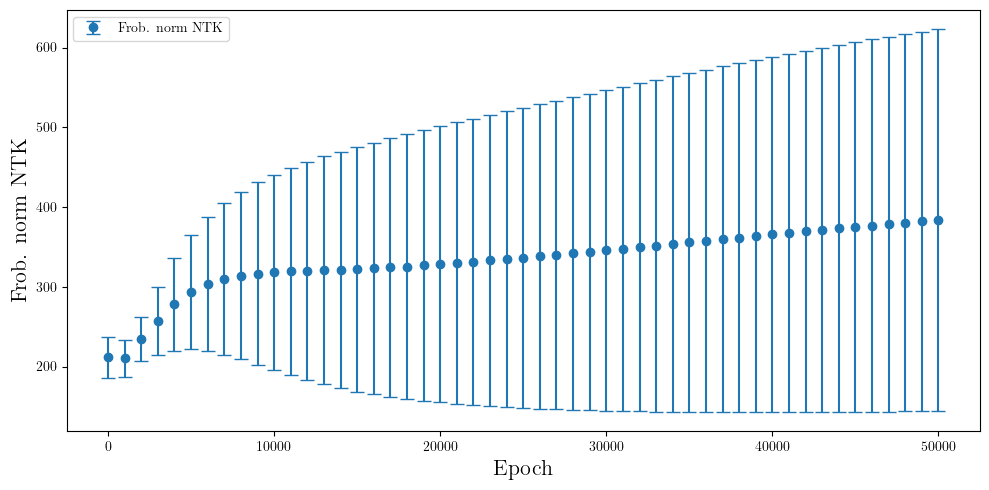

In [14]:
FOLDER_NAME = "ntk_norms"
SAVEDIR = PLOT_FOLDER / FOLDER_NAME
SAVEDIR.mkdir(parents=False, exist_ok=True)

frob_means = np.array([frob.get_mean().squeeze() for frob in frob_norm_time])
frob_stds = np.array([frob.get_std().squeeze() for frob in frob_norm_time])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

if PLOT_ERROR_BARS:
  ax.errorbar(common_epochs, frob_means, yerr=frob_stds, label=r'$\textrm{Frob. norm NTK}$', fmt='o', capsize=5)
else:
  ax.plot(common_epochs, frob_means, label=r'$\textrm{Frob. norm NTK}$')
  ax.fill_between(common_epochs, frob_means - frob_stds, frob_means + frob_stds, alpha=0.5)
  
ax.set_xlabel(r'${\rm Epoch}$', fontsize=16)
ax.set_ylabel(r'$\textrm{Frob. norm NTK}$', fontsize=16)
ax.legend()

fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(SAVEDIR / "NTK_norm.pdf", dpi=300)

# Change in the NTK over time

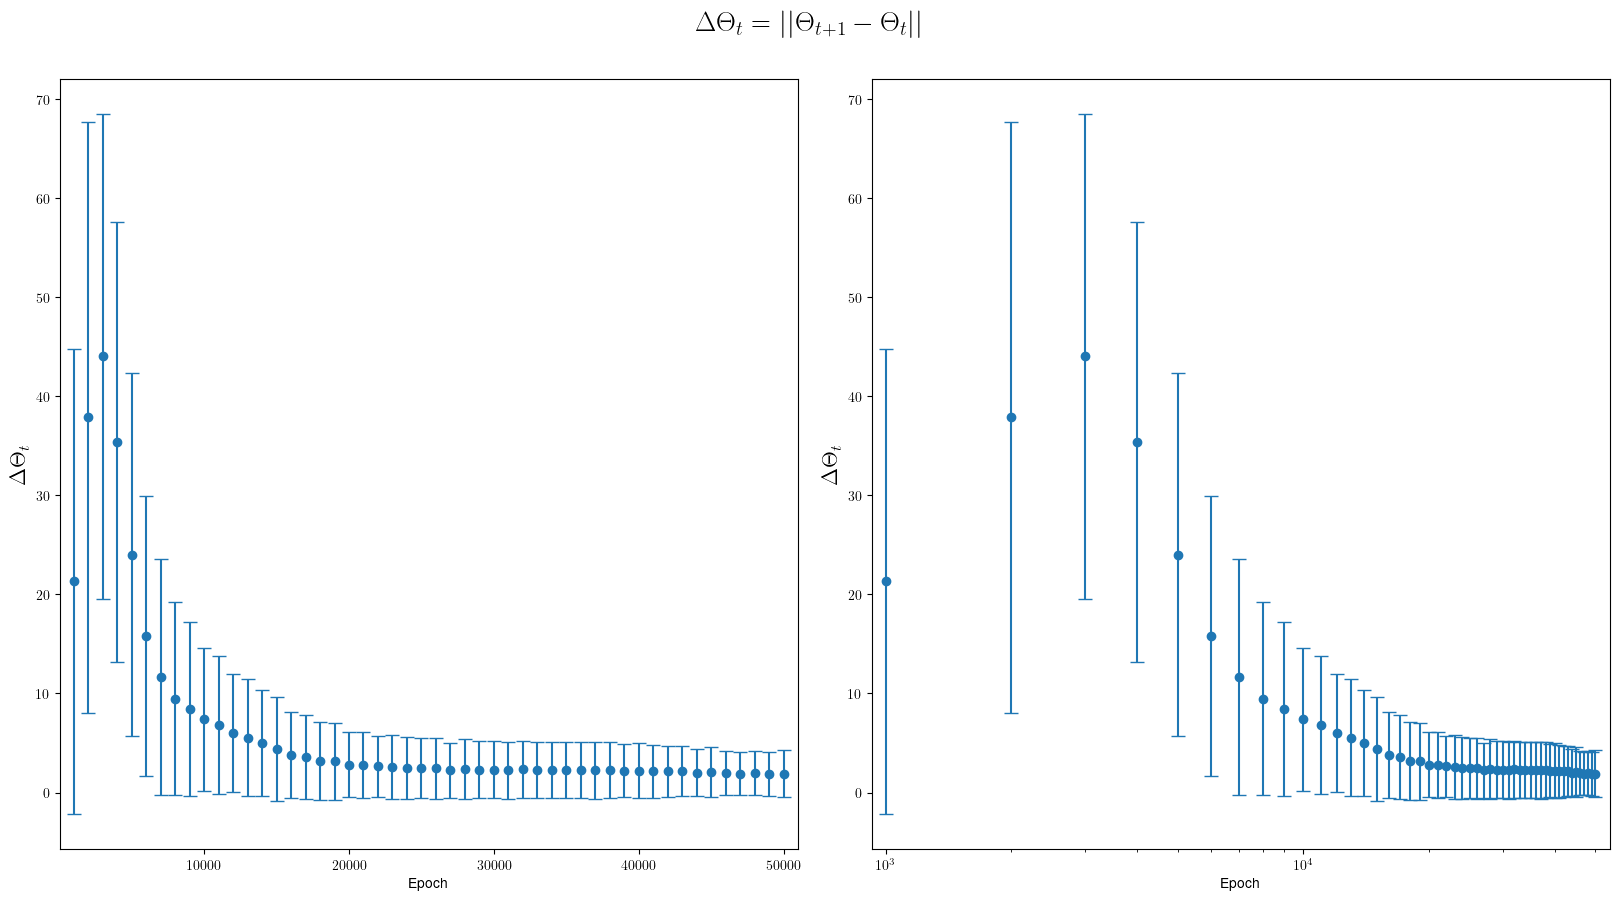

In [15]:
FOLDER_NAME = "delta_ntk"
SAVEDIR = PLOT_FOLDER / FOLDER_NAME
SAVEDIR.mkdir(parents=False, exist_ok=True)

# Compute  \Delta\Theta_t = || \Theta_{t+1} - \Theta_t}||
Delta_ntk_t = []
for i in range(len(NTK_time) - 1):
  delta_ntk_dist = Distribution(f'Delta NTK {i}')
  for rep in range(replicas):
    delta_ntk = np.linalg.norm(NTK_time[i + 1][rep] - NTK_time[i][rep])
    delta_ntk_dist.add(delta_ntk)
  Delta_ntk_t.append(delta_ntk_dist)

delta_ntk_means = np.array([delta.get_mean() for delta in Delta_ntk_t])
delta_ntk_stds = np.array([delta.get_std() for delta in Delta_ntk_t])

fig, axs = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

if PLOT_ERROR_BARS:
  axs[0].errorbar(common_epochs[1:], delta_ntk_means, yerr=delta_ntk_stds, label=r'$\Delta \Theta_t$', fmt='o', capsize=5)
  axs[1].errorbar(common_epochs[1:], delta_ntk_means, yerr=delta_ntk_stds, label=r'$\Delta \Theta_t$', fmt='o', capsize=5)
else:
  axs[0].plot(common_epochs[1:], delta_ntk_means, label=r'$\Delta \Theta_t$')
  axs[0].fill_between(common_epochs[1:], delta_ntk_means - delta_ntk_stds, delta_ntk_means + delta_ntk_stds, alpha=0.5)
  
  axs[1].plot(common_epochs[1:], delta_ntk_means, label=r'$\Delta \Theta_t$')
  axs[1].fill_between(common_epochs[1:], delta_ntk_means - delta_ntk_stds, delta_ntk_means + delta_ntk_stds, alpha=0.5)


axs[0].set_xlabel('Epoch')
axs[0].set_ylabel(r'$\Delta \Theta_t$', fontsize=16)
axs[0].set_xmargin(0.02)

axs[1].set_xlabel('Epoch')
axs[1].set_xscale('log')
axs[1].set_ylabel(r'$\Delta \Theta_t$', fontsize=16)
axs[1].set_xmargin(0.02)

fig.suptitle(r'$\Delta \Theta_t = || \Theta_{t+1} - \Theta_{t}||$', fontsize=20, y=0.95)
if SAVE_PLOT:
  fig.savefig(SAVEDIR / 'delta_ntk.pdf', dpi=300)

  # Save plot separately
  extent_lin = axs[0].get_tightbbox(fig.canvas.get_renderer())
  extent_log = axs[1].get_tightbbox(fig.canvas.get_renderer())
  
  fig.savefig(
    SAVEDIR / "delta_ntk_lin.pdf", dpi=300,
    bbox_inches=extent_lin.transformed(fig.dpi_scale_trans.inverted()).padded(0.15)
  )

  fig.savefig(
    SAVEDIR / "delta_ntk_log.pdf", dpi=300,
    bbox_inches=extent_log.transformed(fig.dpi_scale_trans.inverted()).padded(0.15)
  )

del delta_ntk_means
del delta_ntk_stds
del Delta_ntk_t

# Plot of the eigenvalues

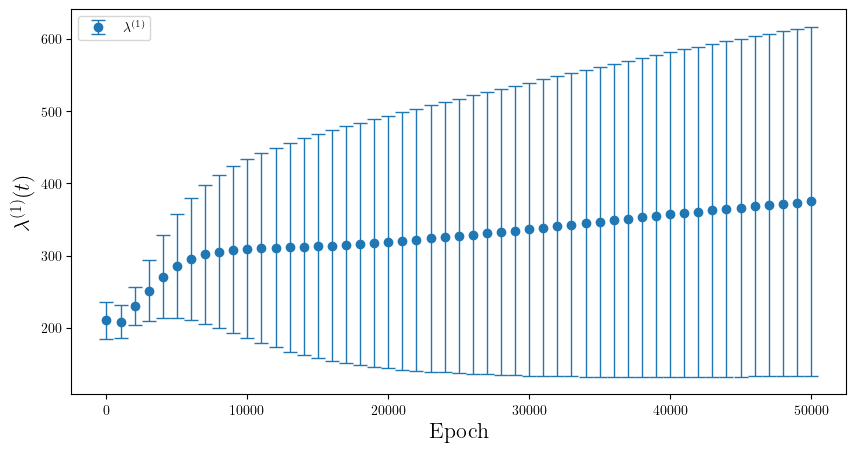

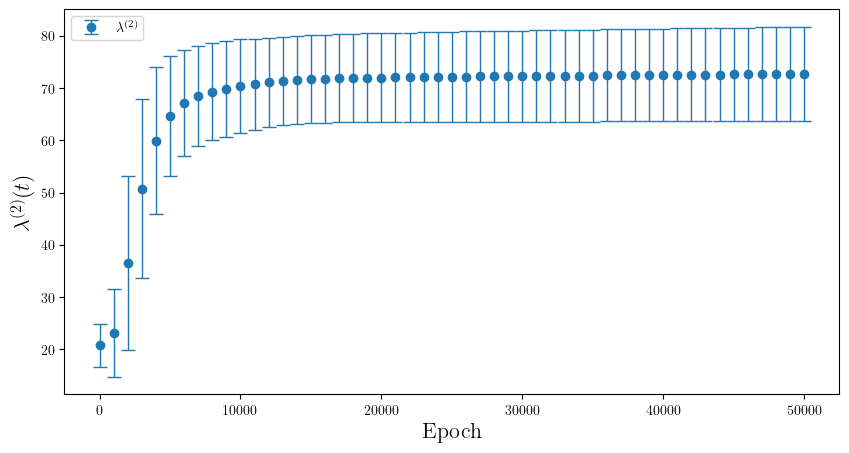

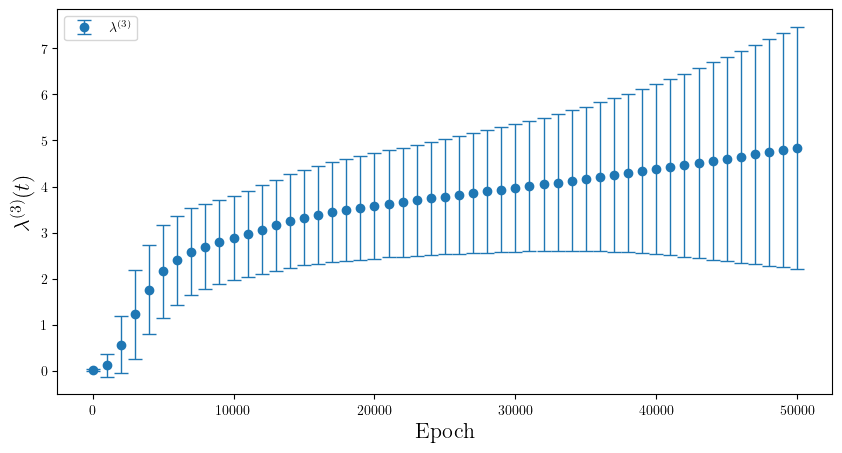

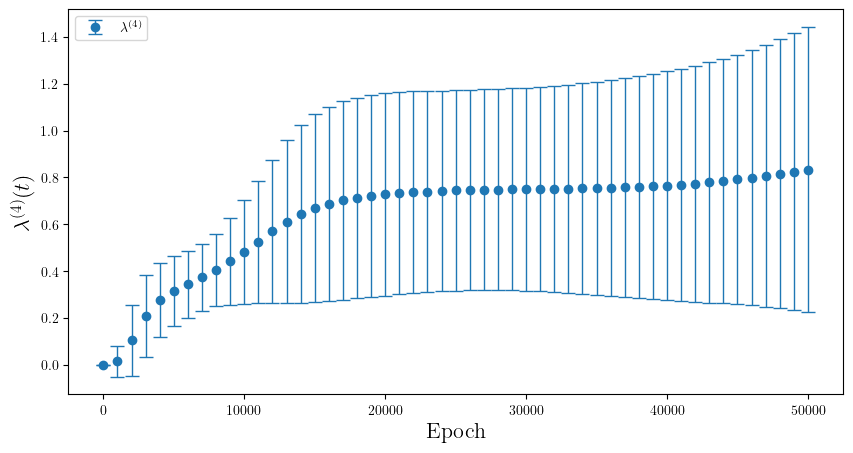

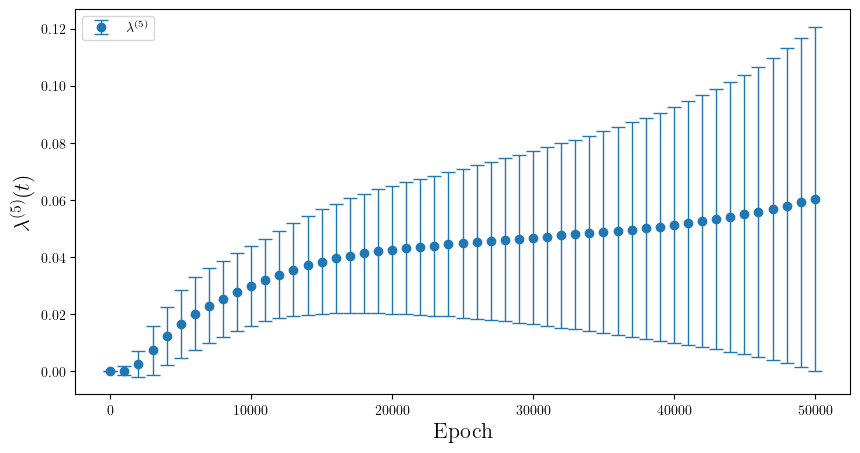

In [16]:
FOLDER_NAME = "ntk_eigenvalues"
SAVEDIR = PLOT_FOLDER / FOLDER_NAME
SAVEDIR.mkdir(parents=False, exist_ok=True)

eigvals_mean = np.array([eigvals.get_mean(axis=0) for eigvals in eigvals_time])
eigvals_std = np.array([eigvals.get_std(axis=0) for eigvals in eigvals_time])

num_eigvals_to_plot = 5  # Number of eigenvalues to plot

for i in range(num_eigvals_to_plot):

  fig, ax = plt.subplots(1, 1, figsize=(10, 5))

  if PLOT_ERROR_BARS:
    ax.errorbar(common_epochs, eigvals_mean[:,i], yerr=eigvals_std[:,i], fmt='o', label=r'$\lambda^{(' + str(i+1) + ')}$', capsize=5, elinewidth=1, markeredgewidth=1)
  else:
    ax.plot(common_epochs, eigvals_mean[:,i], label=r'$\lambda^{(' + str(i+1) + ')}$')
    ax.fill_between(common_epochs, eigvals_mean[:,i] - eigvals_std[:,i], eigvals_mean[:,i] + eigvals_std[:,i], alpha=0.5)

  ax.set_xlabel(r'${\rm Epoch}$', fontsize=16)
  ax.set_ylabel(r'$\lambda^{(' + str(i+1) + ')}(t)$', fontsize=16)
  ax.legend()

  if SAVE_PLOT:
    fig.savefig(SAVEDIR / f"eigval_{i+1}.pdf", dpi=300)

# Plot the error in function of the epochs

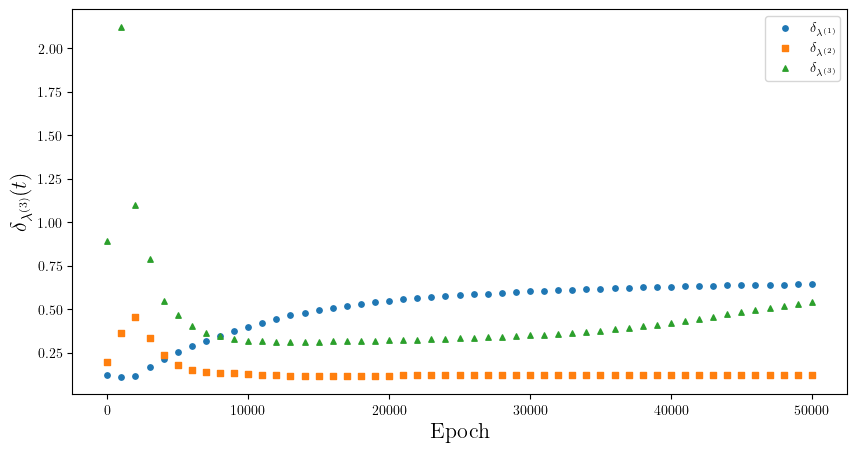

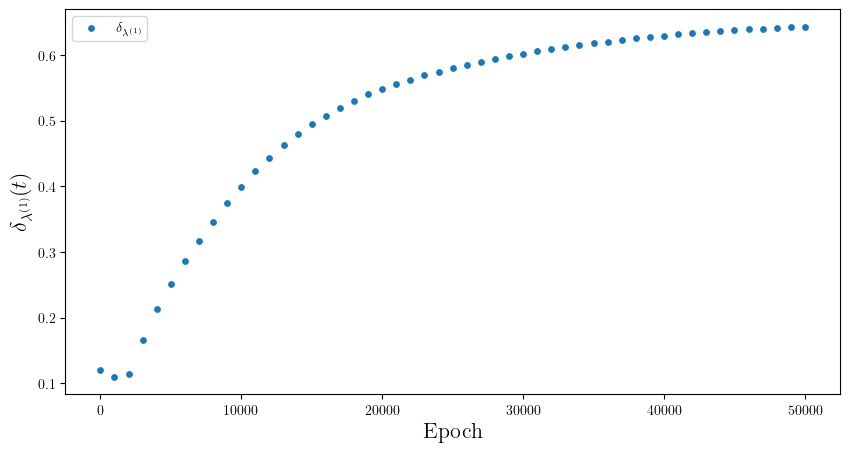

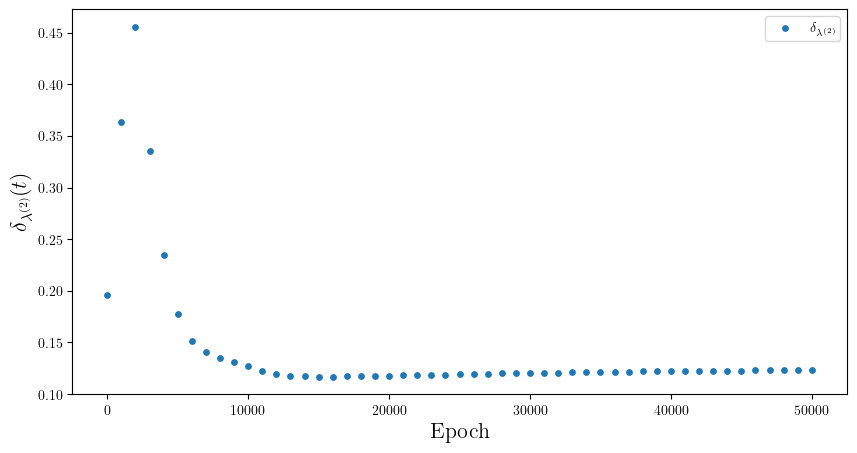

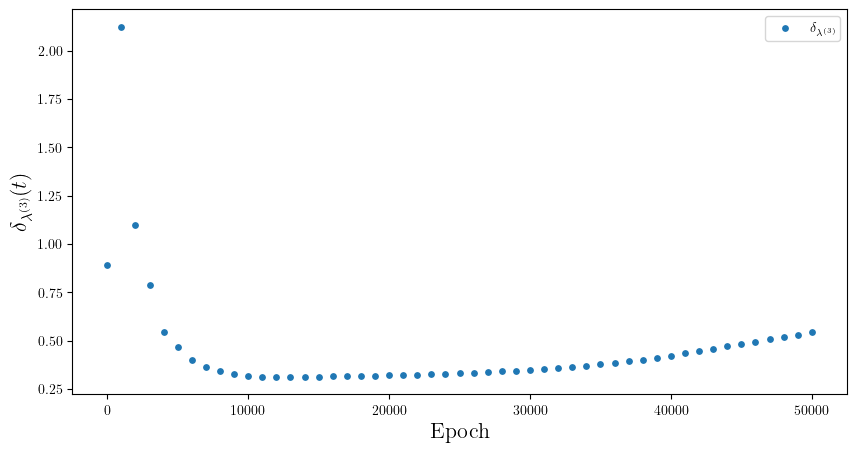

In [17]:
FOLDER_NAME = "ntk_errors"
SAVEDIR = PLOT_FOLDER / FOLDER_NAME
SAVEDIR.mkdir(parents=False, exist_ok=True)

num_eigvals_to_plot = 3  # Number of eigenvalues to plot

point_markers = ['o', 's', '^', 'D', 'x']  # Different markers for each eigenvalue

fig_glob, ax_glob = plt.subplots(1, 1, figsize=(10, 5))

for i in range(num_eigvals_to_plot):

  fig, ax = plt.subplots(1, 1, figsize=(10, 5))

  ax.scatter(common_epochs, eigvals_std[:,i] / eigvals_mean[:,i], label=r'$\delta_{\lambda^{(' + str(i+1) + ')}}$', s=15)
  ax.set_xlabel(r'${\rm Epoch}$', fontsize=16)
  ax.set_ylabel(r'$\delta_{\lambda^{(' + str(i+1) + ')}}(t)$', fontsize=16)
  ax.legend()

  ax_glob.scatter(common_epochs, eigvals_std[:,i] / eigvals_mean[:,i], label=r'$\delta_{\lambda^{(' + str(i+1) + ')}}$', s=15, marker=point_markers[i])

  if SAVE_PLOT:
    fig.savefig(SAVEDIR / f"eigval_{i+1}.pdf", dpi=300)

ax_glob.set_xlabel(r'${\rm Epoch}$', fontsize=16)
ax_glob.set_ylabel(r'$\delta_{\lambda^{(' + str(i+1) + ')}}(t)$', fontsize=16)
ax_glob.legend()

if SAVE_PLOT:
  fig_glob.savefig(SAVEDIR / "glob_eigval_errors.pdf", dpi=300)

del eigvals_std
del eigvals_mean

# Model at initialisation

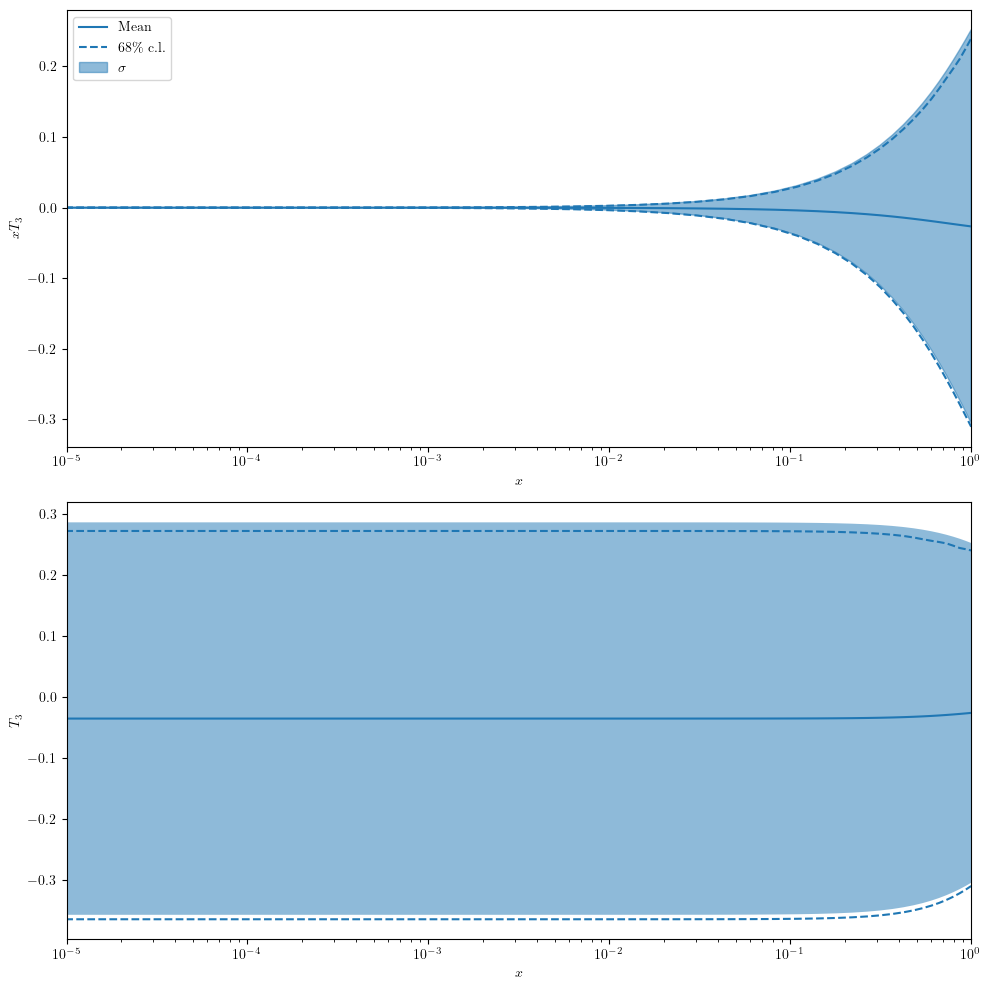

In [18]:
FOLDER_NAME = "model_at_initialisation"
SAVEDIR = PLOT_FOLDER / FOLDER_NAME
SAVEDIR.mkdir(parents=False, exist_ok=True)

# Generating and ensemble of models
replicas = len(replicas_folders)
seed = 1423413
xT3_0 = Distribution('xT3 at initialisation')
for rep in range(replicas):
  model = PDFmodel(
          dense_layer='Dense',
          input=fk_grid,
          outputs=1,
          architecture=metadata['model_info']['architecture'],
          activations=['tanh', 'tanh'],
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed + rep)

  xT3_0.add(model.predict().numpy().reshape(-1))

T3_0 = xT3_0.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at initialisation')

(xt3_lower_bound, xt3_upper_bound) = xT3_0.get_68_percentile()
(t3_lower_bound, t3_upper_bound) = T3_0.get_68_percentile()

# Plot the distribution at initialisation
fig, axs = plt.subplots(2,1, figsize=(10, 10))
axs[0].plot(fk_grid, xT3_0.get_mean(), label=r'${\rm Mean}$', color='C0')
axs[0].plot(fk_grid, xt3_upper_bound, linestyle='--', color='C0', label=r'$\textrm{68\% c.l.}$')
axs[0].plot(fk_grid, xt3_lower_bound, linestyle='--', color='C0')
axs[0].fill_between(fk_grid, xT3_0.get_mean()  - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5, color='C0', label=r'$\sigma$')
axs[0].set_ylabel(r'$xT_3$')
axs[0].set_xlabel(r'$x$')
axs[0].set_xlim([1.e-5,1])

axs[1].plot(fk_grid, T3_0.get_mean(), label=r'${\rm Mean}$', color='C0')
axs[1].fill_between(fk_grid, T3_0.get_mean()  - T3_0.get_std(), T3_0.get_mean() + T3_0.get_std(), alpha=0.5)
axs[1].plot(fk_grid, t3_upper_bound, linestyle='--', color='C0')
axs[1].plot(fk_grid, t3_lower_bound, linestyle='--', color='C0')
axs[1].set_ylabel(r'$T_3$')
axs[1].set_xlabel(r'$x$')
axs[1].set_xlim([1.e-5,1])

axs[0].legend()

fig.tight_layout()
if SAVE_PLOT:

  axs[0].set_xscale('linear')
  axs[1].set_xscale('linear')
  
  fig.savefig(SAVEDIR / 'initialisation_distribution_lin.pdf', dpi=300)

  extent_xt3 = axs[0].get_tightbbox(fig.canvas.get_renderer())
  extent_t3 = axs[1].get_tightbbox(fig.canvas.get_renderer())

  fig.savefig(
    SAVEDIR / "xt3_lin_init.pdf", dpi=300,
    bbox_inches=extent_xt3.transformed(fig.dpi_scale_trans.inverted()).padded(0.15)
  )

  fig.savefig(
    SAVEDIR / "t3_lin_init.pdf", dpi=300,
    bbox_inches=extent_t3.transformed(fig.dpi_scale_trans.inverted()).padded(0.15)
  )

  axs[0].set_xscale('log')
  axs[1].set_xscale('log')

  fig.savefig(SAVEDIR / 'initialisation_distribution_log.pdf', dpi=300)

  extent_xt3 = axs[0].get_tightbbox(fig.canvas.get_renderer())
  extent_t3 = axs[1].get_tightbbox(fig.canvas.get_renderer())

  fig.savefig(
    SAVEDIR / "xt3_log_init.pdf", dpi=300,
    bbox_inches=extent_xt3.transformed(fig.dpi_scale_trans.inverted()).padded(0.15)
  )

  fig.savefig(
    SAVEDIR / "t3_log_init.pdf", dpi=300,
    bbox_inches=extent_t3.transformed(fig.dpi_scale_trans.inverted()).padded(0.15)
  )

# Evolution

In [19]:
def compute_evolution_operator(reference_epoch, t):
    """
    Computes the evolution operator U(t) based on equation 41 in the solution.
    
    Parameters:
    - NTK: Neural Tangent Kernel matrix
    - FK: Forward map matrix
    - Cy: Covariance matrix
    - M: M matrix (typically FK^T @ Cy^-1 @ FK)
    - t: time (epoch)
    
    Returns:
    - U: Evolution operator at time t
    - V: Second operator needed for the full solution
    """

    # Extract index of the reference epoch
    epoch_index = common_epochs.index(reference_epoch)

    Q = Q_by_epoch[epoch_index]
    Qinv = Qinv_by_epoch[epoch_index]
    P_parallel = P_parallel_by_epoch[epoch_index]
    h = h_by_epoch[epoch_index]
    hinv = hinv_by_epoch[epoch_index].make_diagonal()

    Qt = Q.transpose()
    Qtilde = Qt @ M @ P_parallel
    T_tilde = Qt @ FK.T @ Cinv

    exp_ht = h.apply_operator(b=t, operator=lambda a, b: np.exp(- a * b), axis=0, name=f'T3 at initialisation').make_diagonal()
    one_minus_exp = h.apply_operator(b=t, operator=lambda a, b: 1.0 - np.exp(- a * b), axis=0, name=f'T3 at initialisation').make_diagonal()

    U_hat = Q @ exp_ht @ Qinv
    U_check = Q @ hinv @ one_minus_exp @ Qtilde
    V = Q @ hinv @ one_minus_exp @ T_tilde
    
    U = U_hat + U_check + P_parallel
    
    return U, V

def compute_evolution_operator_at_inf(reference_epoch):
    """
    Computes operators at infinity
    
    Parameters:
    - NTK: Neural Tangent Kernel matrix
    - FK: Forward map matrix
    - Cy: Covariance matrix
    - M: M matrix (typically FK^T @ Cy^-1 @ FK)
    - t: time (epoch)
    
    Returns:
    - U: Evolution operator at time t
    - V: Second operator needed for the full solution
    """

    # Extract index of the reference epoch
    epoch_index = common_epochs.index(reference_epoch)

    Q = Q_by_epoch[epoch_index]
    P_parallel = P_parallel_by_epoch[epoch_index]
    hinv = hinv_by_epoch[epoch_index].make_diagonal()
  
    Qt = Q.transpose()
    Qtilde = Qt @ M @ P_parallel
    T_tilde = Qt @ FK.T @ Cinv

    U_check = Q @ hinv @ Qtilde
    V = Q @ hinv @ T_tilde
    
    U = U_check + P_parallel
    
    return U, V

# Check analytical solution at initialisation

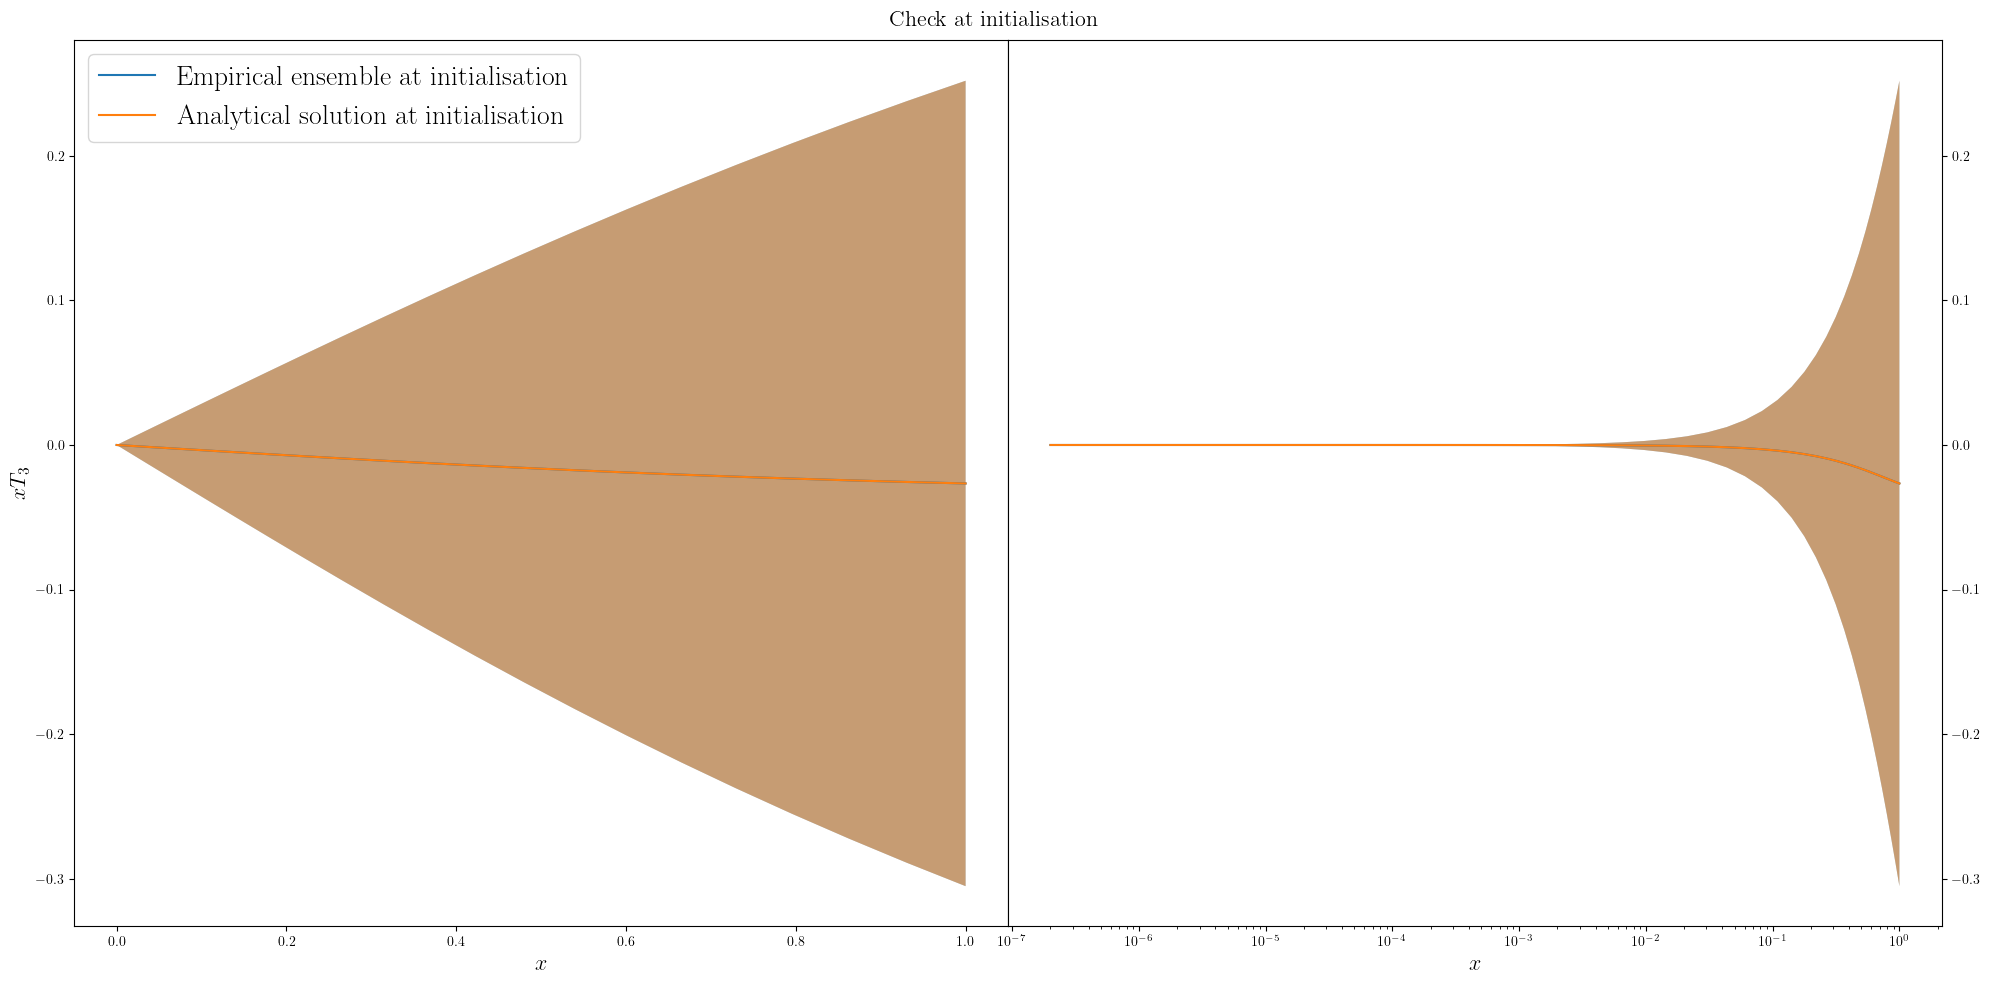

In [20]:
U, V = compute_evolution_operator(20000, 0.0)
xf_t = U @ xT3_0 + V @ data_by_replica_original

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
# xf linaer
axs[0].plot(fk_grid, xT3_0.get_mean(), label=r'$\textrm{Empirical ensemble at initialisation}$')
axs[0].fill_between(fk_grid, xT3_0.get_mean() - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xf_t.get_mean(), label=r'$\textrm{Analytical solution at initialisation}$')
axs[0].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_0.get_mean())
axs[1].fill_between(fk_grid, xT3_0.get_mean() - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xf_t.get_mean())
axs[1].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Check at initialisation}$', fontsize=16)
fig.tight_layout()

# Check solution at infinity

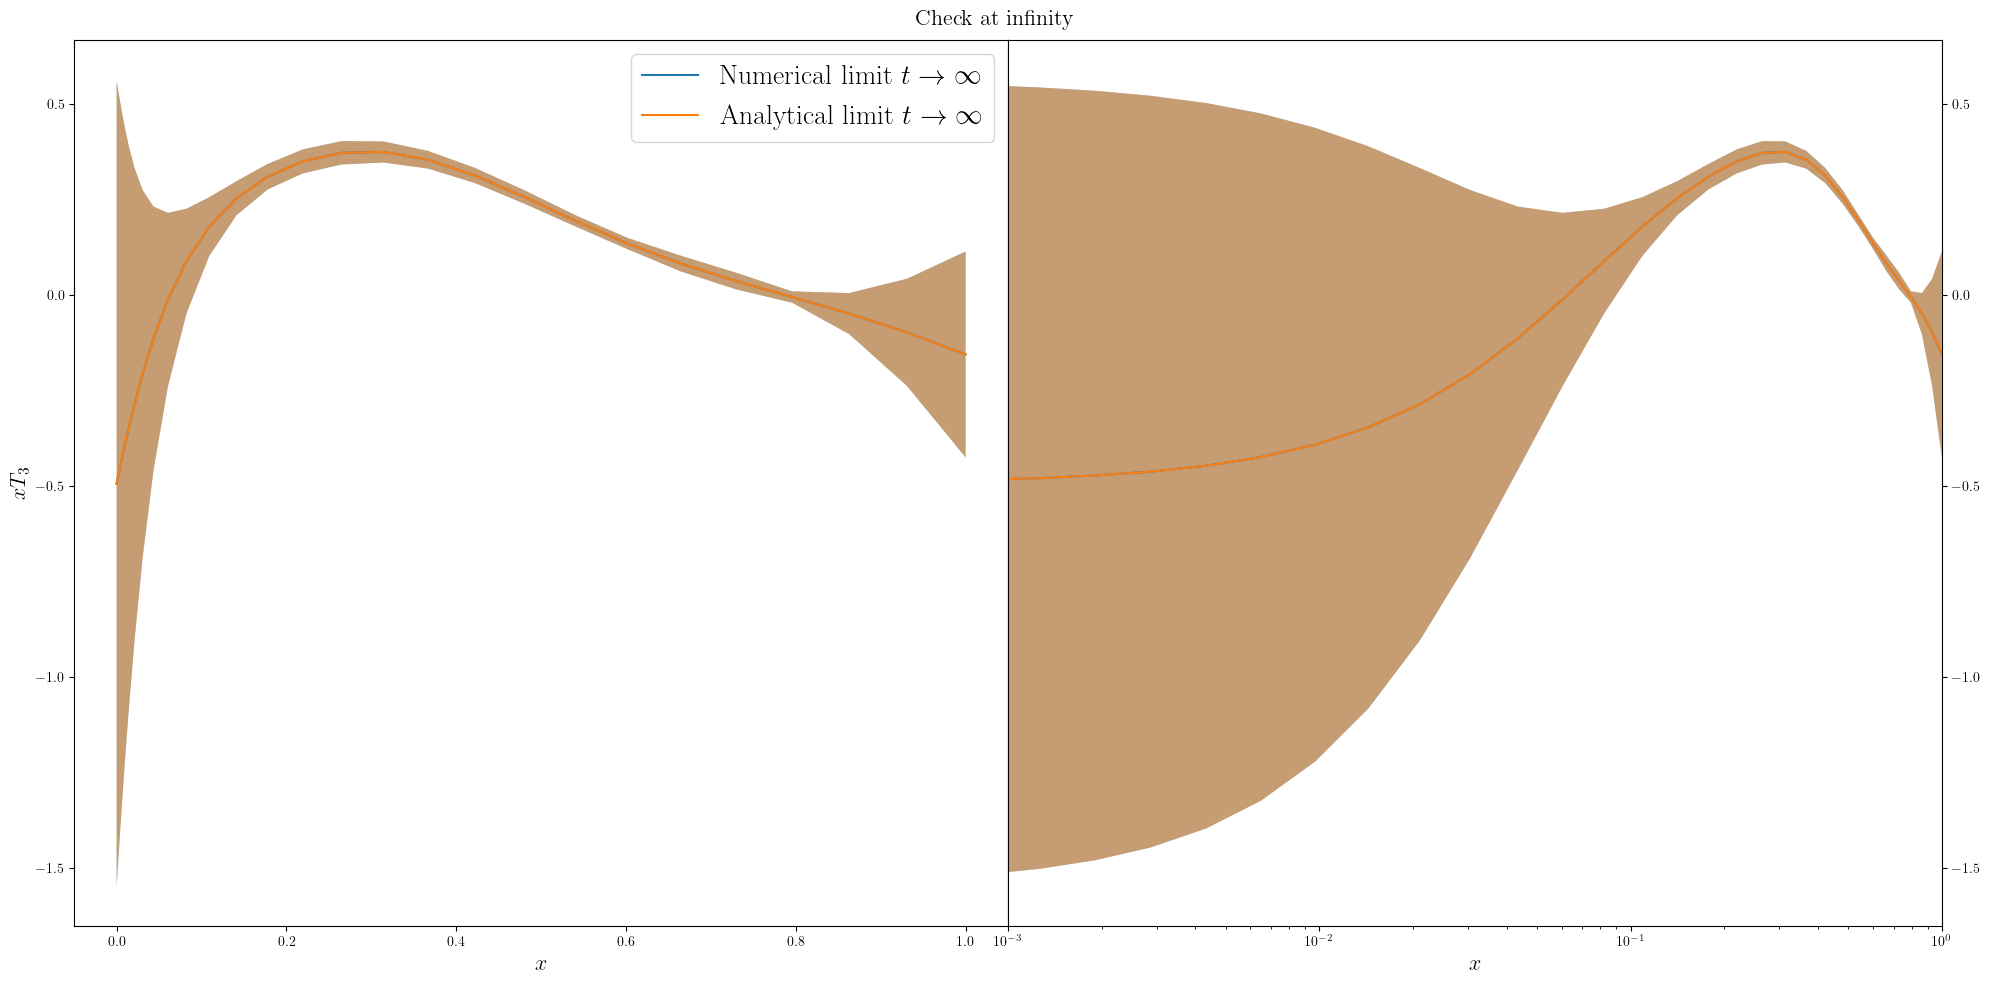

In [21]:
U, V = compute_evolution_operator(30000, 100000)
U_inf, V_inf = compute_evolution_operator_at_inf(30000)

xf_t = U @ xT3_0 + V @ data_by_replica_original
xf_inf = U_inf @ xT3_0 + V_inf @ data_by_replica_original

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
# xf linaer
axs[0].plot(fk_grid, xf_t.get_mean(), label=r'$\textrm{Numerical limit } t\rightarrow \infty$')
axs[0].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xf_inf.get_mean(), label=r'$\textrm{Analytical limit } t\rightarrow \infty$')
axs[0].fill_between(fk_grid, xf_inf.get_mean() - xf_inf.get_std(), xf_inf.get_mean() + xf_inf.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xf_t.get_mean())
axs[1].fill_between(fk_grid, xf_t.get_mean() - xf_t.get_std(), xf_t.get_mean() + xf_t.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xf_inf.get_mean())
axs[1].fill_between(fk_grid, xf_inf.get_mean() - xf_inf.get_std(), xf_inf.get_mean() + xf_inf.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

axs[1].set_xlim(1.e-3, 1)
axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Check at infinity }$', fontsize=16)
fig.tight_layout()

# 1) Analytical solution with random initialisation and ntk from last training epoch

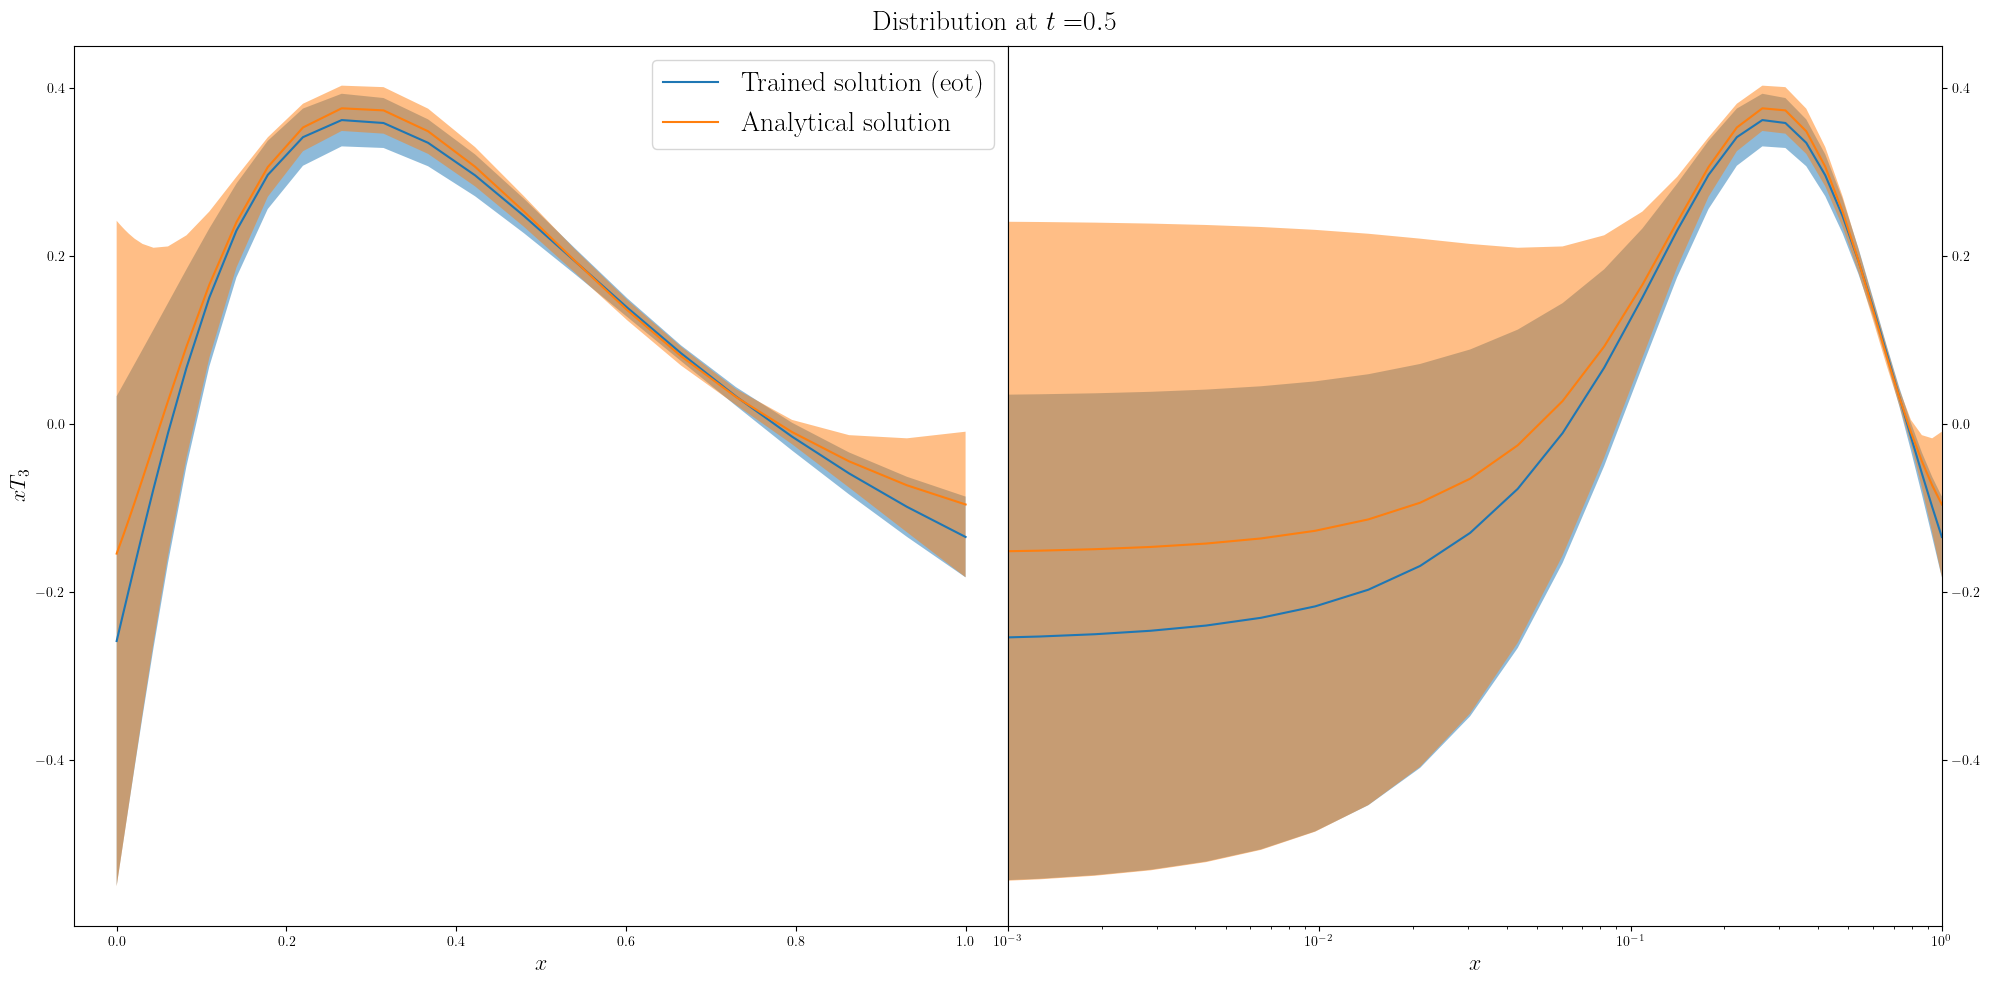

In [22]:
FOLDER_NAME = "case_1"
SAVEDIR = PLOT_FOLDER / FOLDER_NAME
SAVEDIR.mkdir(parents=False, exist_ok=True)

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

t = 0.5
U, V = compute_evolution_operator(30000, t)
xT3_t = U @ xT3_0 + V @ data_by_replica_original


# xf linaer
axs[0].plot(fk_grid, xT3_training.get_mean(), label=r'$\textrm{Trained solution (eot)}$')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_training.get_mean())
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1].set_xlim([1.e-3, 1])


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)
axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(SAVEDIR / 'xT3_1.png', dpi=300)

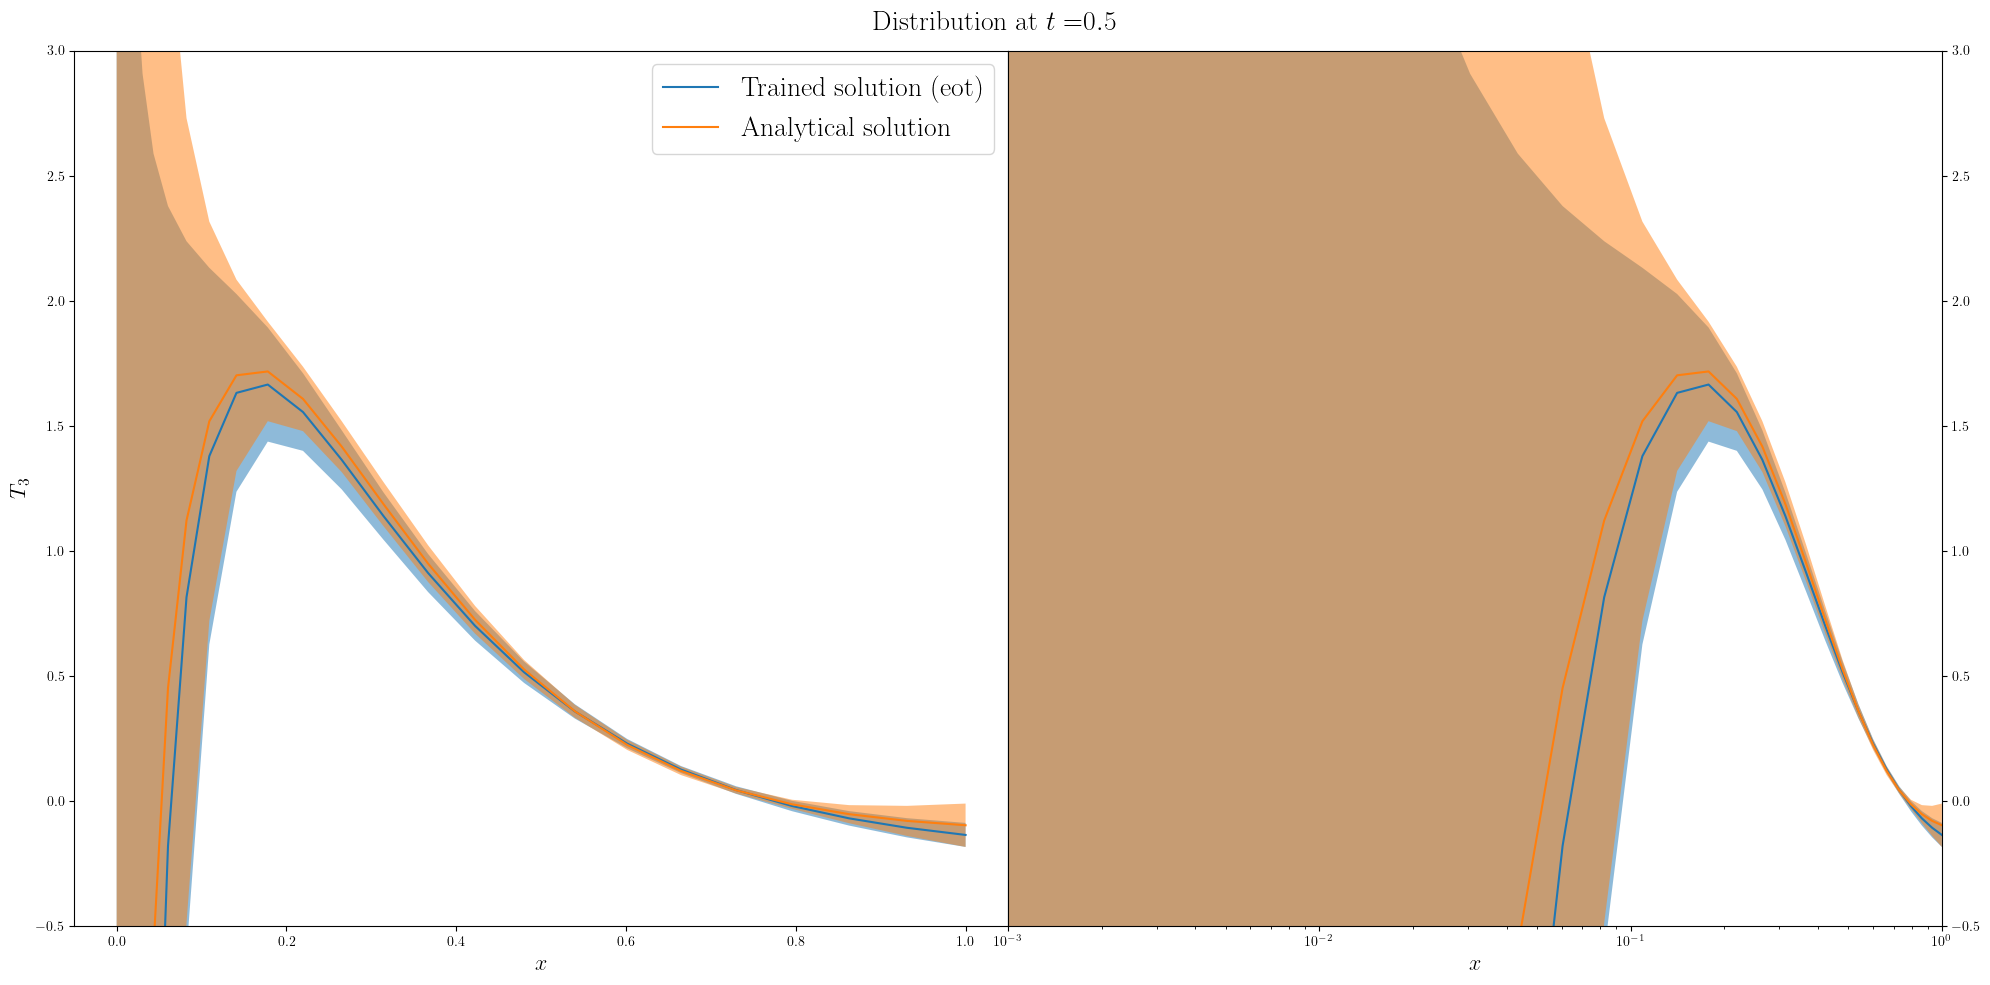

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
T3_t = xT3_t.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at t={t}')

# xf linaer
axs[0].plot(fk_grid, T3_training.get_mean(), label=r'$\textrm{Trained solution (eot)}$')
axs[0].fill_between(fk_grid, T3_training.get_mean() - T3_training.get_std(), T3_training.get_mean() + T3_training.get_std(), alpha=0.5)
axs[0].plot(fk_grid, T3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, T3_t.get_mean() - T3_t.get_std(), T3_t.get_mean() + T3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, T3_training.get_mean())
axs[1].fill_between(fk_grid, T3_training.get_mean() - T3_training.get_std(), T3_training.get_mean() + T3_training.get_std(), alpha=0.5)
axs[1].plot(fk_grid, T3_t.get_mean())
axs[1].fill_between(fk_grid, T3_t.get_mean() - T3_t.get_std(), T3_t.get_mean() + T3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1].set_xlim([1.e-3, 1])

axs[0].set_ylabel(r'$T_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)
axs[0].set_ylim(-0.5,3)
axs[1].set_ylim(-0.5,3)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(SAVEDIR / 'T3_1.png', dpi=300)

# 2) Analytical solution with initial condition at $t = t_{\rm ref}$

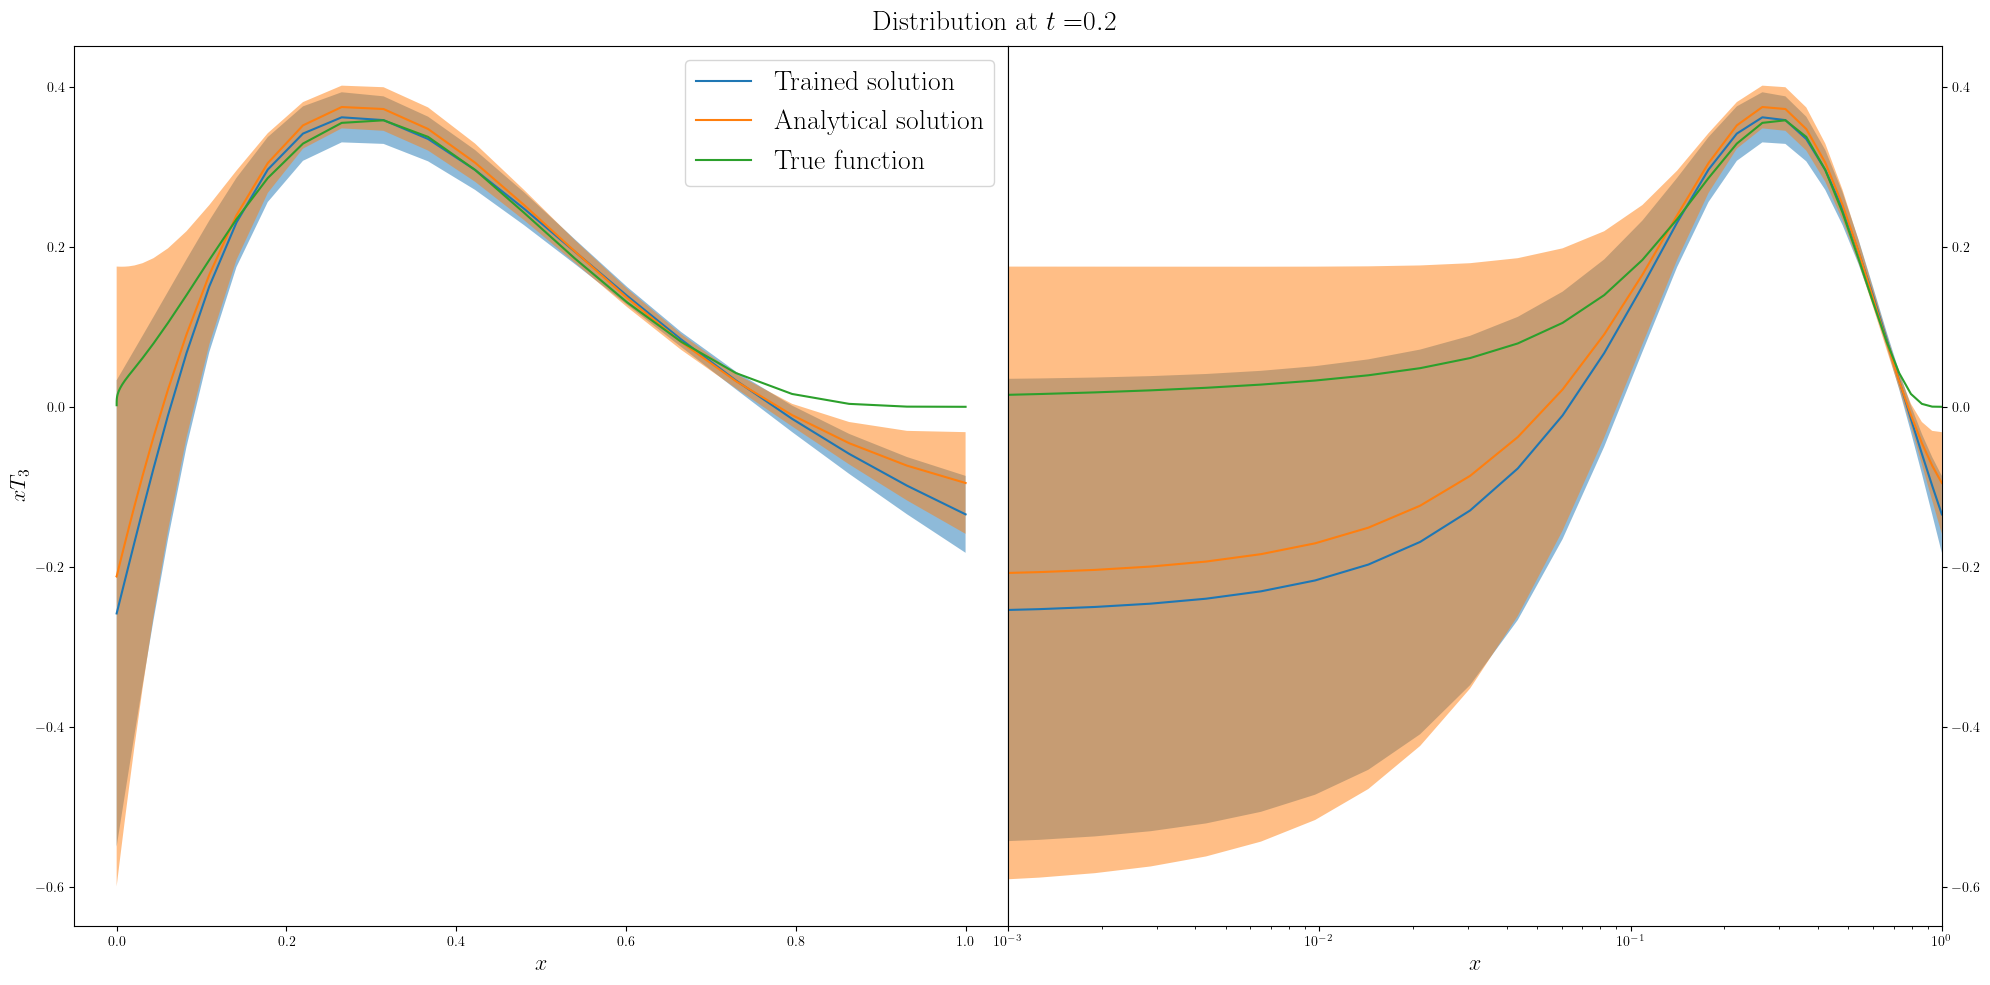

In [24]:
FOLDER_NAME = "case_2"
SAVEDIR = PLOT_FOLDER / FOLDER_NAME
SAVEDIR.mkdir(parents=False, exist_ok=True)
ref_epoch = 30000
xT3_ref = Distribution('xT3 at reference epoch')

# Get trained model at the reference epoch
for replica_path in replicas_folders:
    replica = replica_path.name
    last_epoch = replica_epochs_dict[replica][np.argwhere(np.array(common_epochs) == ref_epoch)[0,0]]

    model = PDFmodel.load_model(replica_path / 'config.json', last_epoch)
    xT3_ref.add(model.predict().numpy().reshape(-1))

t = (common_epochs[-1] - ref_epoch) * learning_rate
U, V = compute_evolution_operator(ref_epoch, t)
xT3_t = U @ xT3_ref + V @ data_by_replica_original

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

# xf linaer
axs[0].plot(fk_grid, xT3_training.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[0].plot(fk_grid, f_bcdms, label=r'$\textrm{True function}$')

# xf log
axs[1].plot(fk_grid, xT3_training.get_mean())
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].plot(fk_grid, f_bcdms, label=r'$\textrm{True function}$')

axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1].set_xlim([1.e-3,1])


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(SAVEDIR / 'xT3_2.png', dpi=300)

# Interplay between $M$ and NTK

In [26]:
Z = eigvecs_time[common_epochs.index(ref_epoch)]
T_tilde = (Z.transpose() @ FK.T).transpose()
T_tilde_mean = T_tilde.get_mean(axis=0)
T_tilde_std = T_tilde.get_std(axis=0)

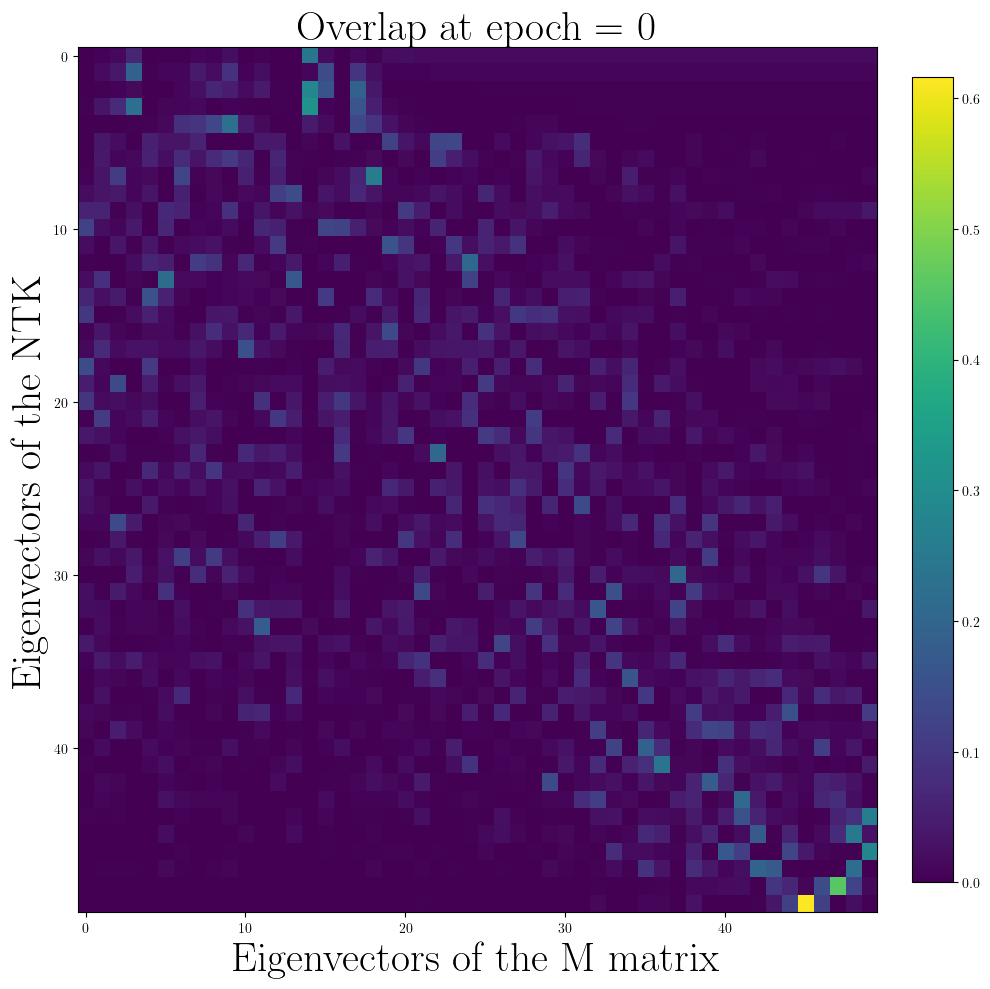

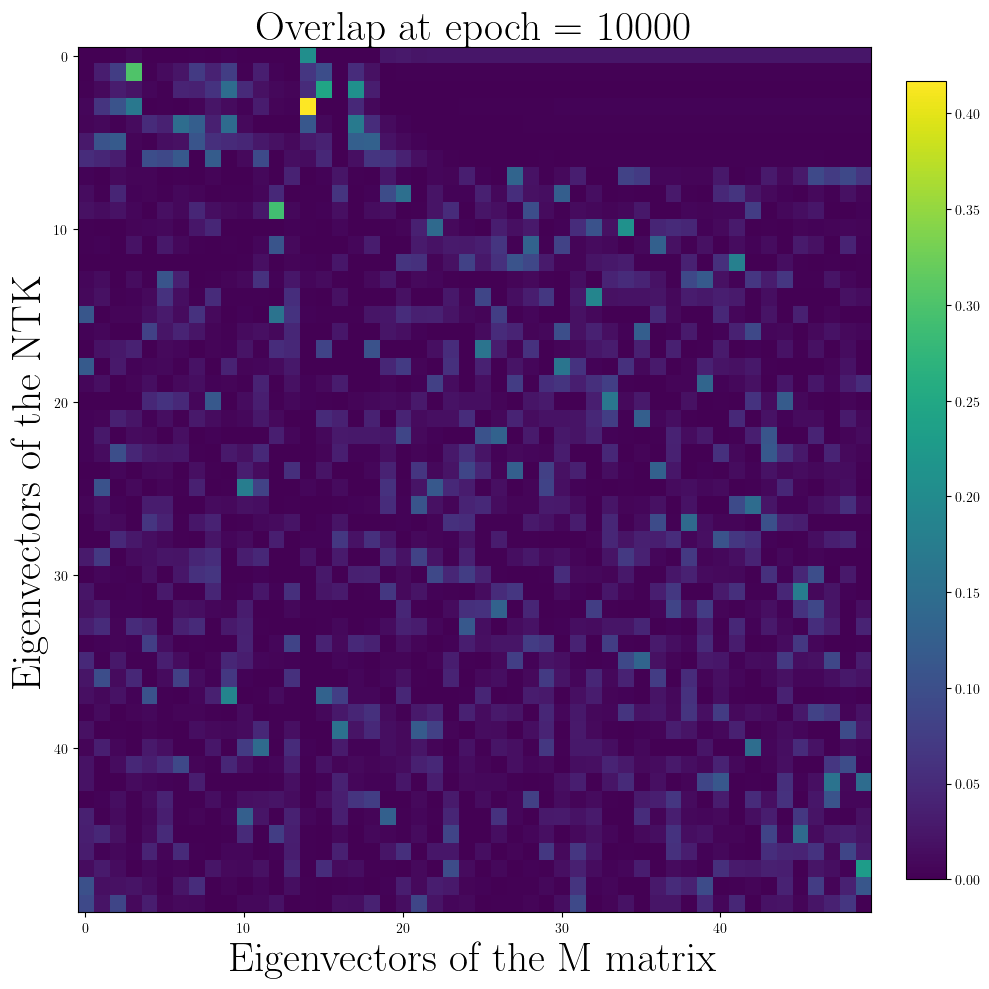

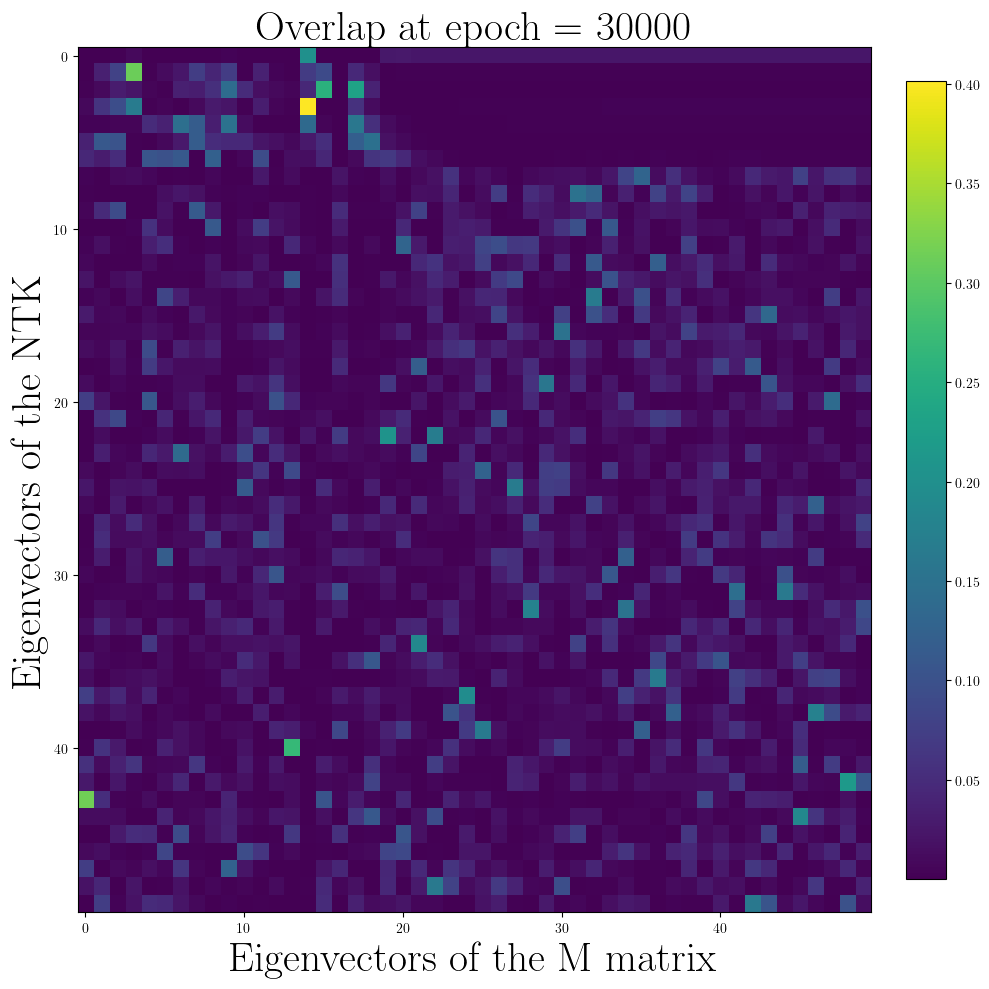

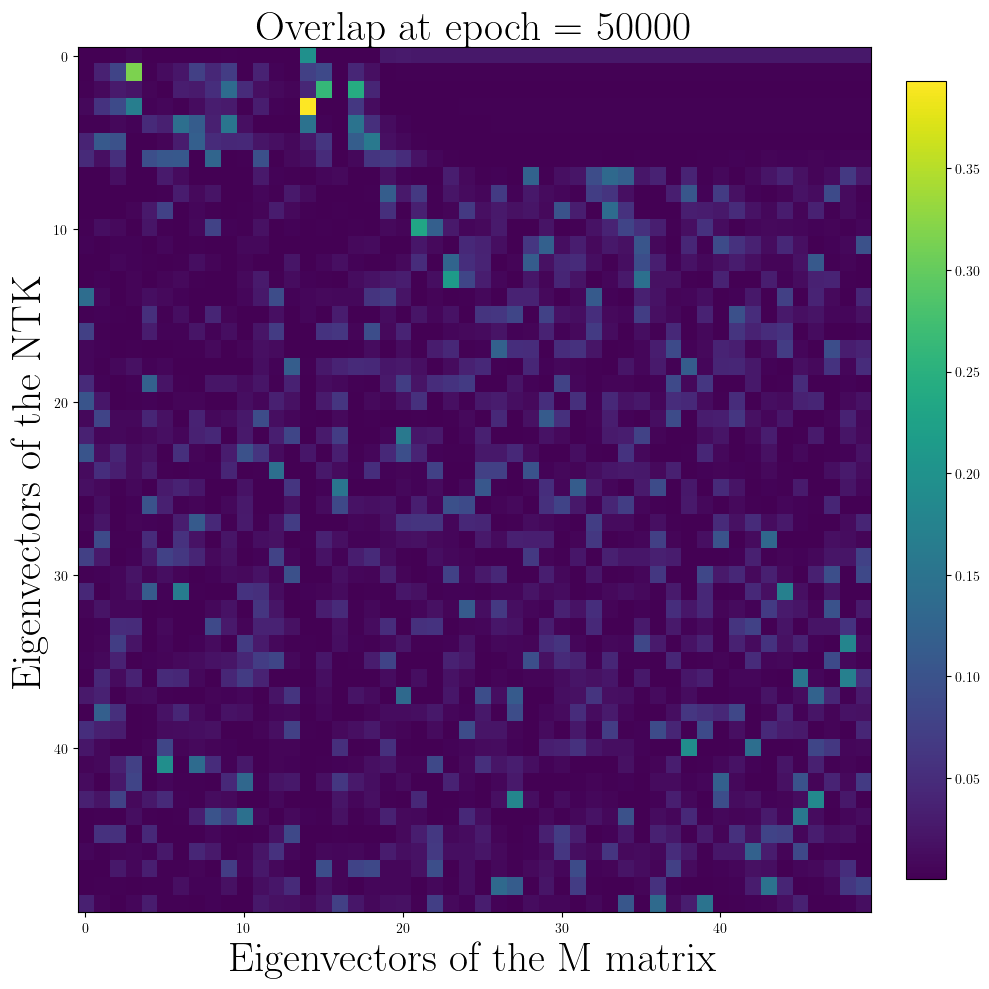

In [28]:
FOLDER_NAME = "ntk_m_overlap"
SAVEDIR = PLOT_FOLDER / FOLDER_NAME
SAVEDIR.mkdir(parents=False, exist_ok=True)

# predictions with eigvectors of the ntk
ref_epochs = [0, 10000, 30000, 50000]
ref_replica = 34 # Random replica

# Compute eigvals and eigvecs of M
m, W = np.linalg.eigh(M)
m = m[::-1]
W = W[:, ::-1]

for ref_epoch in ref_epochs:
  fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  Z = eigvecs_time[common_epochs.index(ref_epoch)]
  cut = cut_by_epoch[common_epochs.index(ref_epoch)]

  A = Z[ref_replica].T @ W
  ms = ax.matshow(np.power(A,2), cmap='viridis', aspect='auto')
  plt.colorbar(ms, ax=ax, fraction=0.046, pad=0.04)

  ax.set_title(r"$\textrm{Overlap at epoch = }" +  f"{ref_epoch}" + r"$", fontsize=30)
  ax.set_ylabel(r'$\textrm{Eigenvectors of the NTK}$', fontsize=30)
  ax.set_xlabel(r'$\textrm{Eigenvectors of the M matrix}$', fontsize=30)
  ax.xaxis.set_ticks_position('bottom')
  ax.xaxis.set_label_position('bottom')

  fig.tight_layout()

  if SAVE_PLOT:
    fig.savefig(SAVEDIR / f'overlap_epoch_{ref_epoch}.pdf', dpi=300)